<a href="https://colab.research.google.com/github/pravatiswain/Potential_talents_Apziva/blob/main/Copy_of_Potential_talents_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement:

A talent sourcing and manageent company finding talented individuals for technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of this job requires a lot of human labor and is full of manual operations. Towards automating this process, they are interested in developing a machine learning powered pipeline that save them time, spot talented individuals, and rank them based on their fitness.


They are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but they expect to first determine best matching candidates based on how fit these candidates are for a given role. They generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role they are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that they were able to list and rank fitting candidates, they then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, they might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, they are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, they expect the list to be re-ranked each time a candidate is starred.

### Data Description:

__Attributes:__

__id__ : unique identifier for candidate (numeric)

__job_title__ : job title for candidate (text)

__location__ : geographical location for candidate (text)

__connections__: number of connections candidate has, 500+ means over 500 (text)

__Output (desired target):__

fit:  how fit the candidate is for the role? (numeric, probability between 0-1)


__Keywords__: “Aspiring human resources” or “seeking human resources”


__Goal(s):__

Predict how fit the candidate is based on their available information (variable fit)


__Success Metric(s):__

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

__Bonus(es):__

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#NLP packages
import re
import nltk

#Text preprocessing packages
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Classification Models
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# load the dataset
talents_df = pd.read_csv('/content/potential-talents - Aspiring human resources - seeking human resources.csv')
talents_df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [7]:
talents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [8]:
len(talents_df)

104

In [9]:
# duplicate rows based on three columns
duplicate_rows = talents_df[talents_df.duplicated(['job_title', 'location', 'connection'])]

# number of duplicate rows
len(duplicate_rows)

51

In [10]:
# Drop duplicate rows
# Considering certain columns for dropping duplicates
talents_df = talents_df.drop_duplicates(subset=['job_title', 'location', 'connection'])
talents_df

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN
10,11,Student at Chapman University,"Lake Forest, California",2,NaN


In [11]:
talents_df = talents_df.reset_index()
talents_df.head(10)

,index,id,job_title,location,connection,fit
0,0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN
9,10,11,Student at Chapman University,"Lake Forest, California",2,NaN


In [12]:
talents_df.drop('index', axis=1, inplace=True)
talents_df.head(10)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN
9,11,Student at Chapman University,"Lake Forest, California",2,NaN


In [13]:
len(talents_df)

53

## Preprocessing

Useful articles on text preprocessing in NLP, Python

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

https://www.youtube.com/watch?v=Fn_U2OG1uqI&list=PLM8wYQRetTxCCURc1zaoxo9pTsoov3ipY&index=6

In [14]:
# Preprocessing
nltk.download('all')
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
nltk.download('omw-1.4')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [15]:
def text_preprocessing(review):
    review = re.sub('[^a-zA-Z]', ' ', review) # keep only alpha (removing numbers and punctions)
    review = str(review).lower()              # Lowercase all text
    review = word_tokenize(review)            # Tokenization
    review = [w for w in review if w not in stop_words] # Removing Stopwords
    #review = [PorterStemmer().stem(w) for w in review]  # stemming (cutting off the prefix and suffix of a word)
    review = [lemma.lemmatize(word=w, pos='v') for w in review] # Lemmatization (reduce to root synonym of a word)
    review = ' '.join(review)
    return review

talents_df['job_title_clean'] = talents_df['job_title'].apply(text_preprocessing) # created a preprocessd text column for job_title
talents_df.head()

,id,job_title,location,connection,fit,job_title_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university


In [16]:
# Comparing the preprocessed text before and after the preprocessing
talents_df['job_title'][0] # text before preprocessing

'2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'

In [17]:
talents_df['job_title_clean'][0] # text after preprocessing

'c bauer college business graduate magna cum laude aspire human resources professional'

In [18]:
# make a histogram of unique words in job_title column
from collections import Counter
results = Counter()
# talents_df['job_title_clean'].str.lower().str.split().apply(results.update)
# print(results)

talents_df['job_title_clean'].apply(lambda x: results.update(x.split()))
print(results)

Counter({'human': 34, 'resources': 34, 'aspire': 13, 'seek': 10, 'professional': 9, 'manager': 7, 'university': 6, 'student': 6, 'management': 6, 'business': 5, 'generalist': 5, 'specialist': 4, 'position': 4, 'opportunities': 3, 'director': 3, 'major': 3, 'college': 2, 'graduate': 2, 'english': 2, 'coordinator': 2, 'hr': 2, 'senior': 2, 'internship': 2, 'retail': 2, 'staff': 2, 'north': 2, 'america': 2, 'information': 2, 'systems': 2, 'leader': 2, 'c': 1, 'bauer': 1, 'magna': 1, 'cum': 1, 'laude': 1, 'native': 1, 'teacher': 1, 'epik': 1, 'program': 1, 'korea': 1, 'people': 1, 'development': 1, 'ryan': 1, 'advisory': 1, 'board': 1, 'member': 1, 'celal': 1, 'bayar': 1, 'humber': 1, 'hris': 1, 'chapman': 1, 'svp': 1, 'chro': 1, 'market': 1, 'communications': 1, 'csr': 1, 'officer': 1, 'engie': 1, 'houston': 1, 'woodlands': 1, 'energy': 1, 'gphr': 1, 'sphr': 1, 'intercontinental': 1, 'buckhead': 1, 'atlanta': 1, 'experience': 1, 'recruit': 1, 'luxottica': 1, 'groupe': 1, 'beneteau': 1, 'r

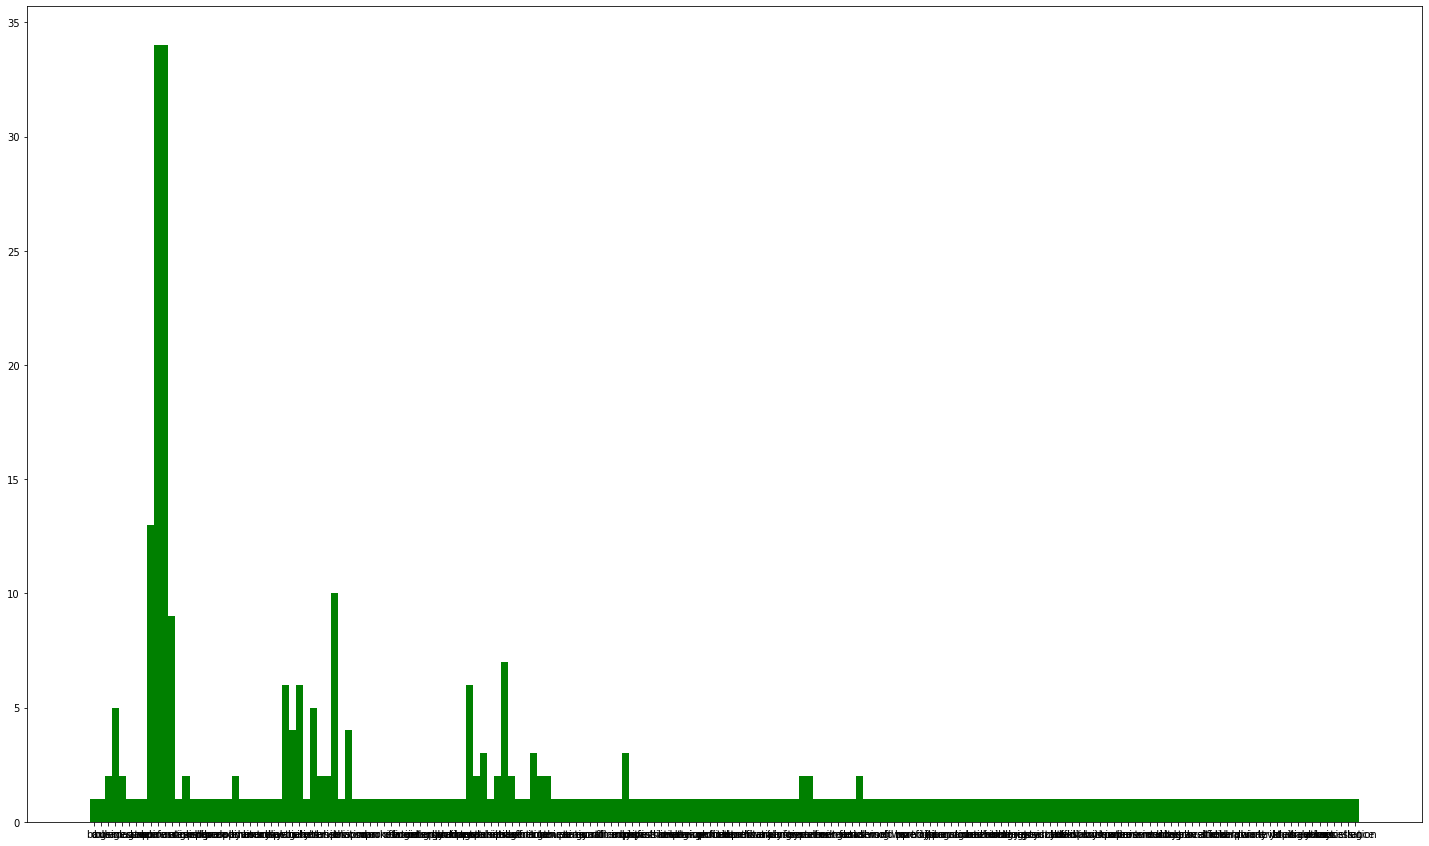

In [19]:
pos = np.arange(len(results.keys()))
width = 1     # gives histogram aspect to the bar diagram
plt.figure(figsize=(25, 15))
plt.bar(results.keys(), results.values(), width, color='g')
plt.show()

In [20]:
# Replacement of very common abbreviation with full form in the job_title column
# replace HR, SVP, CHRO with full form

replacers = {'hr': 'humane resources',
 'svp': 'senior vice president',
 'chro': 'chief human resources officer'}

talents_df['job_title_clean'] = talents_df['job_title_clean'].str.split().apply(lambda x: ' '.join([replacers.get(w, w) for w in x]))
talents_df['job_title_clean'][10] # in this sentence 'svp' and 'chro' got replaced

'senior vice president chief human resources officer market communications csr officer engie houston woodlands energy gphr sphr'

In [21]:
# Remove '+' sign form conection column, string to numeric
talents_df['connection'] = talents_df['connection'].str.replace('+', '').astype(int)
# talents_df['connection'] = pd.to_numeric(talents_df['connection'])
talents_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,id,job_title,location,connection,fit,job_title_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500,NaN,advisory board member celal bayar university


In [22]:
# lowercase the location column
talents_df['location'] = talents_df['location'].str.lower()
talents_df.head()

,id,job_title,location,connection,fit,job_title_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"houston, texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,kanada,500,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"denton, texas",500,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"i̇zmir, türkiye",500,NaN,advisory board member celal bayar university


In [23]:
talents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               53 non-null     int64  
 1   job_title        53 non-null     object 
 2   location         53 non-null     object 
 3   connection       53 non-null     int64  
 4   fit              0 non-null      float64
 5   job_title_clean  53 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.6+ KB


In [24]:
# converting the location data: Kanada to Canada
location_replacer = {'kanada': 'canada'}
talents_df['location'] = talents_df['location'].str.split().apply(lambda x: ' '.join([location_replacer.get(w, w) for w in x]))
talents_df.head(10)

,id,job_title,location,connection,fit,job_title_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"houston, texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,canada,500,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"denton, texas",500,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"i̇zmir, türkiye",500,NaN,advisory board member celal bayar university
5,6,Aspiring Human Resources Specialist,greater new york city area,1,NaN,aspire human resources specialist
6,7,Student at Humber College and Aspiring Human R...,canada,61,NaN,student humber college aspire human resources ...
7,8,HR Senior Specialist,san francisco bay area,500,NaN,humane resources senior specialist
8,10,Seeking Human Resources HRIS and Generalist Po...,greater philadelphia area,500,NaN,seek human resources hris generalist position
9,11,Student at Chapman University,"lake forest, california",2,NaN,student chapman university


In [25]:
# convert location data to geoloaction data

In [26]:
# 

In [27]:
talents_df_clean = talents_df.copy()
talents_df_clean.head()

,id,job_title,location,connection,fit,job_title_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"houston, texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,canada,500,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"denton, texas",500,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"i̇zmir, türkiye",500,NaN,advisory board member celal bayar university


Articles on vectorizers and cosine similarity:
https://medium.com/@adriensieg/text-similarities-da019229c894

https://www.youtube.com/watch?v=Ey81KfQ3PQU

https://medium.com/web-mining-is688-spring-2021/cosine-similarity-and-tfidf-c2a7079e13fa

https://www.youtube.com/watch?v=oiTxx6L5aDQ&t=576s

## Machine Learning

### Vectorize and create document-term matrix with TfidfVectorizer

In [28]:
# Create TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(talents_df['job_title_clean'])

# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

(53, 179)


In [29]:
df = pd.DataFrame(tfidf_matrix.toarray(), columns= tfidf_vectorizer.get_feature_names())
df.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administration,administrative,admissions,advisory,always,america,analyst,analytics,army,arts,...,university,vice,victoria,wellington,western,westfield,within,woodlands,work,world
48,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.530452,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.000000,0.0,0.0,0.0,0.57735,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.519642,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
keyword_1 = 'Aspiring human resources'
keyword_2 = 'seeking human resources'
# preprocessing of key words
keyword_1_clean = text_preprocessing(keyword_1)
keyword_2_clean = text_preprocessing(keyword_2)
print(keyword_1_clean)
print(keyword_2_clean)

aspire human resources
seek human resources


In [31]:
tfidf_keyword_1 = tfidf_vectorizer.transform([keyword_1_clean]) # vectorize the keyword_1
print(tfidf_keyword_1.shape)

(1, 179)


In [32]:
tfidf_keyword_2 = tfidf_vectorizer.transform([keyword_2_clean]) # vectorize the keyword_2
print(tfidf_keyword_2.shape)

(1, 179)


In [33]:
# Using sklearn module to calculate the cosine similarity between two vector lists
# compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_keyword_1)
# print(cosine_sim)

In [34]:
# create a DataFrame fo the cosine similarity matrix
tfidf_sim = pd.DataFrame(cosine_sim, columns= ['tfidf_cosine_key1']) 
tfidf_sim.head()

,tfidf_cosine_key1
0,0.271057
1,0.000000
2,0.756172
3,0.000000
4,0.000000


In [35]:
# compute and print the cosine similarity matrix
cosine_sim_2 = cosine_similarity(tfidf_matrix, tfidf_keyword_2)
# print(cosine_sim)
tfidf_sim['tfidf_cosine_key2'] = cosine_sim_2
tfidf_sim.head()

,tfidf_cosine_key1,tfidf_cosine_key2
0,0.271057,0.10918
1,0.000000,0.00000
2,0.756172,0.30458
3,0.000000,0.00000
4,0.000000,0.00000


In [36]:
# concatenate the DataFrames of cosine similarity matrix and talents_df dataset
talents_df_sim = pd.concat([talents_df,tfidf_sim], axis=1)
talents_df_sim.head()

,id,job_title,location,connection,fit,job_title_clean,tfidf_cosine_key1,tfidf_cosine_key2
0,1,2019 C.T. Bauer College of Business Graduate (...,"houston, texas",85,NaN,c bauer college business graduate magna cum la...,0.271057,0.10918
1,2,Native English Teacher at EPIK (English Progra...,canada,500,NaN,native english teacher epik english program korea,0.000000,0.00000
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional,0.756172,0.30458
3,4,People Development Coordinator at Ryan,"denton, texas",500,NaN,people development coordinator ryan,0.000000,0.00000
4,5,Advisory Board Member at Celal Bayar University,"i̇zmir, türkiye",500,NaN,advisory board member celal bayar university,0.000000,0.00000


In [37]:
len(talents_df_sim)

53

In [38]:
# rank the job title based on cosine similarity
talents_df_rank = talents_df_sim.sort_values('tfidf_cosine_key1', ascending=False)
talents_df_rank

,id,job_title,location,connection,fit,job_title_clean,tfidf_cosine_key1,tfidf_cosine_key2
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional,0.756172,0.304580
45,97,Aspiring Human Resources Professional,"kokomo, indiana area",71,NaN,aspire human resources professional,0.756172,0.304580
5,6,Aspiring Human Resources Specialist,greater new york city area,1,NaN,aspire human resources specialist,0.676482,0.272482
21,73,"Aspiring Human Resources Manager, seeking inte...","houston, texas area",7,NaN,aspire human resources manager seek internship...,0.612564,0.627952
12,27,Aspiring Human Resources Management student se...,"houston, texas area",500,NaN,aspire human resources management student seek...,0.434827,0.460927
20,72,Business Management Major and Aspiring Human R...,"monroe, louisiana area",5,NaN,business management major aspire human resourc...,0.432466,0.174194
14,66,Experienced Retail Manager and aspiring Human ...,"austin, texas area",57,NaN,experience retail manager aspire human resourc...,0.404462,0.162914
22,74,Human Resources Professional,greater boston area,16,NaN,human resources professional,0.393751,0.371455
6,7,Student at Humber College and Aspiring Human R...,canada,61,NaN,student humber college aspire human resources ...,0.392015,0.157900
48,100,Aspiring Human Resources Manager | Graduating ...,"cape girardeau, missouri",103,NaN,aspire human resources manager graduate may se...,0.354679,0.363589


### TfidfVectorization for Trigrams

In [ ]:
# instantiate the tfidf vectorizer for trigrams
tfidf_vectorizer_trigrams = TfidfVectorizer(ngram_range = (3,3))
# Generate matrix of word vectors
tfidf_matrix_trigrams = tfidf_vectorizer_trigrams.fit_transform(talents_df['job_title_clean'])

# Print the shape of tfidf_matrix
print(tfidf_matrix_trigrams.shape)

(53, 196)


In [ ]:
tfidf_vectorizer_trigrams.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['administration excellence log',
 'admissions representative community',
 'advisory board member',
 'always set success',
 'america groupe beneteau',
 'army national guard',
 'arts major aspire',
 'aspire human resources',
 'assistant styczynski lab',
 'bachelor science biology',
 'bauer college business',
 'biology victoria university',
 'board member celal',
 'brand portfolio executive',
 'business graduate magna',
 'business intelligence analytics',
 'business management major',
 'business management retail',
 'business partner heil',
 'celal bayar university',
 'center long beach',
 'chief human resources',
 'college aspire human',
 'college business graduate',
 'communications csr officer',
 'community medical center',
 'conflict management policies',
 'coordinator intercontinental buckhead',
 'create inclusive engage',
 'csr officer engie',
 'cum laude aspire',
 'customer service patient',
 'delphi hardware paint',
 'development coordinator ryan',
 'director administration excel

In [ ]:
# vectorize the keyword_1 and keyword_2
tfidf_key1_trigram = tfidf_vectorizer_trigrams.transform([keyword_1_clean]) # vectorize the keyword_1
tfidf_key2_trigram = tfidf_vectorizer_trigrams.transform([keyword_2_clean]) # vectorize the keyword_2

print(tfidf_key1_trigram.shape)
print(tfidf_key2_trigram.shape)

(1, 196)
(1, 196)


In [ ]:
# compute and print the cosine similarity matrix
cosine_key1_trigram = cosine_similarity(tfidf_matrix_trigrams, tfidf_key1_trigram)
cosine_key2_trigram = cosine_similarity(tfidf_matrix_trigrams, tfidf_key2_trigram)
# create a DataFrame fo the cosine similarity matrix
tfidf_trigram_cosine = pd.DataFrame(cosine_key1_trigram, columns= ['tfidf_key1_trigram']) 
tfidf_trigram_cosine['tfidf_key2_trigram'] = cosine_key2_trigram
tfidf_trigram_cosine.head()

,tfidf_key1_trigram,tfidf_key2_trigram
0,0.196858,0.0
1,0.000000,0.0
2,0.643971,0.0
3,0.000000,0.0
4,0.000000,0.0


In [ ]:
# concatenate the DataFrames of cosine similarity matrix and talents_df dataset
talents_df_cosine = pd.concat([talents_df_sim,tfidf_trigram_cosine], axis=1)
talents_df_cosine.head()

,id,job_title,location,connection,fit,job_title_clean,tfidf_cosine_key1,tfidf_cosine_key2,tfidf_key1_trigram,tfidf_key2_trigram
0,1,2019 C.T. Bauer College of Business Graduate (...,"houston, texas",85,NaN,c bauer college business graduate magna cum la...,0.271057,0.10918,0.196858,0.0
1,2,Native English Teacher at EPIK (English Progra...,canada,500,NaN,native english teacher epik english program korea,0.000000,0.00000,0.000000,0.0
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional,0.756172,0.30458,0.643971,0.0
3,4,People Development Coordinator at Ryan,"denton, texas",500,NaN,people development coordinator ryan,0.000000,0.00000,0.000000,0.0
4,5,Advisory Board Member at Celal Bayar University,"i̇zmir, türkiye",500,NaN,advisory board member celal bayar university,0.000000,0.00000,0.000000,0.0


In [ ]:
# rank the job title based on cosine similarity
talents_df_rank = talents_df_cosine.sort_values(['tfidf_cosine_key1', 'tfidf_key1_trigram'], ascending=[False, False])
talents_df_rank

,id,job_title,location,connection,fit,job_title_clean,tfidf_cosine_key1,tfidf_cosine_key2,tfidf_key1_trigram,tfidf_key2_trigram
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional,0.756172,0.304580,0.643971,0.000000
45,97,Aspiring Human Resources Professional,"kokomo, indiana area",71,NaN,aspire human resources professional,0.756172,0.304580,0.643971,0.000000
5,6,Aspiring Human Resources Specialist,greater new york city area,1,NaN,aspire human resources specialist,0.676482,0.272482,0.517034,0.000000
21,73,"Aspiring Human Resources Manager, seeking inte...","houston, texas area",7,NaN,aspire human resources manager seek internship...,0.612564,0.627952,0.244574,0.000000
12,27,Aspiring Human Resources Management student se...,"houston, texas area",500,NaN,aspire human resources management student seek...,0.434827,0.460927,0.269520,0.000000
20,72,Business Management Major and Aspiring Human R...,"monroe, louisiana area",5,NaN,business management major aspire human resourc...,0.432466,0.174194,0.279783,0.000000
14,66,Experienced Retail Manager and aspiring Human ...,"austin, texas area",57,NaN,experience retail manager aspire human resourc...,0.404462,0.162914,0.283559,0.000000
22,74,Human Resources Professional,greater boston area,16,NaN,human resources professional,0.393751,0.371455,0.000000,0.000000
6,7,Student at Humber College and Aspiring Human R...,canada,61,NaN,student humber college aspire human resources ...,0.392015,0.157900,0.276355,0.000000
48,100,Aspiring Human Resources Manager | Graduating ...,"cape girardeau, missouri",103,NaN,aspire human resources manager graduate may se...,0.354679,0.363589,0.166279,0.000000


## Word2Vec Model

useful articles: [1](https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92), [2](https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92), [3](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db), [4](https://towardsdatascience.com/the-simple-approach-to-word-embedding-for-natural-language-processing-using-python-ae028c8dbfd2), [5](https://www.youtube.com/watch?v=_Rt4LjasO34&list=PLM8wYQRetTxCCURc1zaoxo9pTsoov3ipY&index=4)




In [ ]:
import gensim
import gensim.downloader as api

In [ ]:
# load word2vec model
word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# word2vec_model['pravati'] # keyword error; word 'pravati' not in vocabulary

In [39]:
# define a function for word embedding

def avg_word_embedding(sentence, model):
    words = sentence.split()
    word_embedding = []
    for word in words:
        if word in model:
            word_embedding.append(model[word])
        else:
            word_embedding.append(np.zeros(300)) # append zero vectors if the word is not present in the corpus
    #print(word_embedding)
    #print(type(word_embedding))
    #print(len(word_embedding))
    # print('word_embedding[0].shape:%s'% word_embedding[0].shape)
    word_embedding_avg = np.mean(word_embedding, axis=0)
    #return np.mean(word_embedding, axis=0)
    return word_embedding_avg


In [ ]:
avg_keyword_embedding = avg_word_embedding(keyword_1_clean, word2vec_model)
avg_keyword_embedding

array([-2.37630215e-02,  4.34977226e-02,  1.75292969e-01,  1.48152664e-01,
       -1.67643223e-02, -1.77408848e-02,  3.20638031e-01, -9.01692733e-02,
       -7.48697892e-02, -6.42496720e-02, -1.29231766e-01,  1.80301666e-02,
       -3.05989590e-02,  7.68229142e-02, -8.86230469e-02,  1.67480469e-01,
       -9.30175781e-02,  2.03613281e-01,  1.37736006e-02,  5.47281886e-03,
       -1.88639328e-01, -2.13765457e-01,  4.98657227e-02,  4.61120605e-02,
        1.44856766e-01,  1.23697920e-02, -1.52018234e-01,  9.65169296e-02,
       -1.92057285e-02, -1.46423340e-01, -4.70377617e-02,  3.45052071e-02,
       -8.33333358e-02, -7.73111954e-02, -5.72916679e-02, -2.36002598e-02,
       -1.02539062e-02,  1.28011063e-01,  1.46484375e-01,  6.14420585e-02,
        4.28873710e-02,  9.87955704e-02, -8.13802064e-04,  8.23465958e-02,
       -4.60510254e-02, -8.17057267e-02, -1.54296875e-01,  2.54557282e-01,
       -5.76171875e-02, -8.72294139e-03, -1.41601562e-02, -1.29394531e-01,
       -6.97021484e-02,  

In [ ]:
print(avg_keyword_embedding.shape)

(300,)


In [ ]:
talents_df_clean.head()

,id,job_title,location,connection,fit,job_title_clean
0,1,2019 C.T. Bauer College of Business Graduate (...,"houston, texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,canada,500,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"denton, texas",500,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"i̇zmir, türkiye",500,NaN,advisory board member celal bayar university


In [ ]:
# create job title word embeddings
job_title_embeddings = []
for row in talents_df_clean['job_title_clean']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_title_embeddings.append(avg_word_embedding(row,word2vec_model))
len(job_title_embeddings)    

53

In [ ]:
job_title_embeddings[1].shape

(300,)

In [ ]:
job_title_embeddings[1]

array([ 0.0140904 ,  0.01974051,  0.05472238,  0.06389509,  0.02669634,
        0.06742641,  0.07603237, -0.01349749, -0.08358329,  0.06033761,
        0.02263532, -0.19520787, -0.11056083, -0.1484375 , -0.01412528,
        0.1484375 ,  0.02539062,  0.10365513,  0.02727836, -0.1645159 ,
        0.0476423 ,  0.17173549,  0.05636161, -0.03648158, -0.08691406,
       -0.05252511, -0.11079979,  0.04354422,  0.03045654,  0.05200553,
        0.05050223,  0.03970773, -0.1832101 , -0.08600725, -0.05957031,
        0.04370117, -0.01647949,  0.11941964,  0.1357945 ,  0.05310822,
        0.04338728, -0.11429269,  0.10353306,  0.17613002,  0.07784598,
       -0.01158796, -0.00351388, -0.02329799, -0.17755999,  0.13929967,
       -0.15652902, -0.06302316,  0.11315046, -0.02444894, -0.04115513,
       -0.00240653, -0.20382254, -0.07342529,  0.034729  , -0.1796875 ,
        0.07665689, -0.07696097, -0.06724984, -0.11898368, -0.03393555,
       -0.13152204, -0.05872672,  0.0395159 ,  0.01206752,  0.07

### Cosine Similarity

__Cosine Similarity measures the similarity between two vectors or vector lists by calculating the cosine angle between two vectors or two vectors lists.__

It is one of the most wodely used and powerful similarity measure used in multiple applications such as finding similar documents in NLP, information retrieval, finding similar sequence to a DNA in bioinformatics, detecting plagiarism and may more in Data Science. 

__Cosine Similarity Calculations__

__Angle between two 2-D vectors A and B__
<img src= 'https://miro.medium.com/max/1332/1*AqWG1VHnLf8P7_H4KDBwVQ.png' width='400'/>

__Calculation of cosine angle between A and B__

<img src="https://miro.medium.com/max/1400/1*LfW66-WsYkFqWc4XYJbEJg.png" width="400"/>



For cosine function, if theta = 0, cos(theta) = 1 and for theta = 180, cos(theta) = -1. Which means, for two overlapping vectors the the value of cosine is maximum and minimum for two opposite vectors. 

__Value of cosine at different angle__
<img src="https://miro.medium.com/max/1400/1*tTPC_CFlHlQ1oyPsn9zRqQ.png" width="600">
<img src="https://miro.medium.com/max/1400/1*17iIvBSo_BS9T3Ww7hUdkg.png" width="600">


Ueful articles and videos about cosine similarity: [1](https://www.youtube.com/watch?v=9ivlcQuRMdY), [2](https://www.delftstack.com/howto/python/cosine-similarity-between-lists-python/),
[3](https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db)



In [40]:
# define a function for cosine similarity
def cosine_similarity(vec_A, vec_B):
    cos_sim = np.dot(vec_A, vec_B)/(np.linalg.norm(vec_A)* np.linalg.norm(vec_B))
    return cos_sim

In [ ]:
similarity_scores = []
for job_title_embedding in job_title_embeddings:
    similarity_scores.append(cosine_similarity(avg_keyword_embedding, job_title_embedding))
print(similarity_scores)

[0.56903595, 0.15717483822198566, 0.9439335, 0.3119312, 0.19871562591342384, 0.9118496, 0.8069560847029358, 0.5485424, 0.7423809, 0.18276498, 0.5179214619533282, 0.5973435828493919, 0.7684145, 0.77286994, 0.78469664, 0.7111249, 0.716826750820615, 0.5857916123765637, 0.55977464, 0.6815239670104014, 0.7669995, 0.8791082, 0.8333684, 0.650036805452405, 0.75771236, 0.6059215, 0.7752722629731661, 0.72629863, 0.27688923, 0.63771707, 0.75596523, 0.5221294329468176, 0.64613783, 0.23777728695530362, 0.35603774, 0.25274307, 0.70884544, 0.65558285, 0.29330821637514864, 0.25798425, 0.3966898, 0.2747202, 0.60641, 0.23803797516023437, 0.3208425282930256, 0.9439335, 0.13984618, 0.77344865, 0.79498625, 0.7752722629731661, 0.2811973, 0.27217188, 0.30739927]


In [ ]:
talents_df_clean['fit'] = similarity_scores
talents_df_word2vec = talents_df_clean.rename({'fit': 'fit_word2vec'}, axis=1)
talents_df_word2vec.sort_values('fit_word2vec',ascending=False ).head(10) # top 10 candidates 

,id,job_title,location,connection,fit_word2vec,job_title_clean
45,97,Aspiring Human Resources Professional,"kokomo, indiana area",71,0.943933,aspire human resources professional
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,0.943933,aspire human resources professional
5,6,Aspiring Human Resources Specialist,greater new york city area,1,0.911850,aspire human resources specialist
21,73,"Aspiring Human Resources Manager, seeking inte...","houston, texas area",7,0.879108,aspire human resources manager seek internship...
22,74,Human Resources Professional,greater boston area,16,0.833368,human resources professional
6,7,Student at Humber College and Aspiring Human R...,canada,61,0.806956,student humber college aspire human resources ...
48,100,Aspiring Human Resources Manager | Graduating ...,"cape girardeau, missouri",103,0.794986,aspire human resources manager graduate may se...
14,66,Experienced Retail Manager and aspiring Human ...,"austin, texas area",57,0.784697,experience retail manager aspire human resourc...
49,101,Human Resources Generalist at Loparex,"raleigh-durham, north carolina area",500,0.775272,human resources generalist loparex
26,78,Human Resources Generalist at Schwan's,amerika birleşik devletleri,500,0.775272,human resources generalist schwan


## GloVe: Global Vectors for Word Representation

Link to the article: https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words.

In [ ]:
# load glove model
glove_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
avg_keyword_embedding_glove = avg_word_embedding(keyword_1_clean, glove_model)
avg_keyword_embedding_glove

array([ 7.89033324e-02,  4.04054016e-01, -2.97096670e-01, -5.52633367e-02,
        1.39003336e-01,  8.62133279e-02,  1.19983338e-01,  2.59050012e-01,
        1.58376664e-01, -1.56396008e+00,  3.58366638e-01,  2.53333300e-02,
       -4.13329989e-01,  1.34310024e-02, -1.22383237e-02, -2.24336669e-01,
        6.20833188e-02,  2.77323335e-01, -1.11970007e-01, -1.31755665e-01,
       -1.94920003e-01,  3.40373367e-01,  1.34881005e-01, -4.54876684e-02,
        1.24236643e-02,  2.07376659e-01,  5.04176676e-01,  4.28933293e-01,
        5.72333336e-02, -4.37680036e-02,  4.05095816e-01,  3.99366654e-02,
       -2.99087375e-01, -2.53435999e-01,  8.44596699e-02,  1.39933424e-02,
        8.86499956e-02,  1.39134333e-01,  1.64063320e-01, -2.70596653e-01,
        1.83599889e-02,  1.65666884e-03, -2.11316332e-01, -5.22616692e-02,
       -1.06818326e-01,  7.35903308e-02, -1.57701328e-01,  3.81146669e-01,
        3.05259675e-01, -1.93580672e-01,  7.42890015e-02,  1.73720002e-01,
       -6.73966706e-02, -

In [ ]:
print(avg_keyword_embedding_glove.shape)

(300,)


In [ ]:
# create job title word embeddings
job_title_embeddings_glove = []
for row in talents_df_clean['job_title_clean']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_title_embeddings_glove.append(avg_word_embedding(row,glove_model))
len(job_title_embeddings_glove)  

53

In [ ]:
print(job_title_embeddings_glove[1].shape)

(300,)


In [ ]:
job_title_embeddings_glove[1]

array([-4.30001438e-01, -3.88605706e-02,  1.25244275e-01, -1.36776581e-01,
       -1.72839567e-01, -9.66476575e-02, -9.58667174e-02, -1.12625360e-01,
       -1.15313292e-01, -8.24905276e-01,  1.25102714e-01,  2.75075734e-01,
        2.95168590e-02,  1.64557427e-01,  1.68039694e-01,  5.81281446e-02,
        1.79977730e-01, -4.74072807e-02, -3.82712856e-02, -1.60356134e-01,
       -2.47066408e-01, -9.20622870e-02, -1.61509722e-01,  4.57429469e-01,
       -1.92377135e-01, -3.42856557e-03, -2.24701408e-02,  7.39160851e-02,
       -4.10351418e-02,  2.03770980e-01,  4.50728536e-02, -4.09587212e-02,
       -8.37737322e-02,  2.19765976e-01, -3.38390559e-01, -1.22214304e-02,
        1.93980888e-01, -1.93738416e-01, -1.86232835e-01,  7.29078650e-02,
        3.04228067e-03, -1.68921128e-01, -2.38921382e-02,  2.06251010e-01,
       -1.10776901e-01, -2.67325877e-03,  6.29745722e-02,  4.10404116e-01,
        4.04628478e-02, -2.58808583e-01,  9.77312848e-02,  1.03145704e-01,
        1.01773717e-01, -

In [ ]:
similarity_scores_glove = []
for job_title_embedding in job_title_embeddings_glove:
    similarity_scores_glove.append(cosine_similarity(avg_keyword_embedding_glove, job_title_embedding))
print(similarity_scores_glove)

[0.51045966, 0.2601416, 0.9130016, 0.4921338, 0.23803127, 0.92626506, 0.70151246, 0.5728213, 0.795287545467219, 0.21408789, 0.5387392546782979, 0.59068596, 0.79264146, 0.82515323, 0.7478453, 0.72537357, 0.69217557, 0.6401472, 0.5894276, 0.7849299109380554, 0.74427855, 0.8994836, 0.8238091, 0.6983900244933727, 0.79002124, 0.67870724, 0.677839, 0.7498853, 0.37233043, 0.6986046, 0.7524271, 0.5257851, 0.70004725, 0.26839656, 0.5315893, 0.30186015, 0.7636879, 0.7386923, 0.3689281997178648, 0.3687963, 0.50819546, 0.39468998, 0.7088763, 0.2977297, 0.31572992, 0.9130016, 0.24636914, 0.81959784, 0.76888263, 0.8045733218353652, 0.33934426, 0.41741577, 0.41682553]


In [ ]:
talents_df_clean['fit'] = similarity_scores_glove
talents_df_glove = talents_df_clean.rename({'fit': 'fit_glove'}, axis=1)
talents_df_glove.sort_values('fit_glove',ascending=False ).head(10) # top 10 candidates 

,id,job_title,location,connection,fit_glove,job_title_clean
5,6,Aspiring Human Resources Specialist,greater new york city area,1,0.926265,aspire human resources specialist
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,0.913002,aspire human resources professional
45,97,Aspiring Human Resources Professional,"kokomo, indiana area",71,0.913002,aspire human resources professional
21,73,"Aspiring Human Resources Manager, seeking inte...","houston, texas area",7,0.899484,aspire human resources manager seek internship...
13,28,Seeking Human Resources Opportunities,"chicago, illinois",390,0.825153,seek human resources opportunities
22,74,Human Resources Professional,greater boston area,16,0.823809,human resources professional
47,99,Seeking Human Resources Position,"las vegas, nevada area",48,0.819598,seek human resources position
49,101,Human Resources Generalist at Loparex,"raleigh-durham, north carolina area",500,0.804573,human resources generalist loparex
8,10,Seeking Human Resources HRIS and Generalist Po...,greater philadelphia area,500,0.795288,seek human resources hris generalist position
12,27,Aspiring Human Resources Management student se...,"houston, texas area",500,0.792641,aspire human resources management student seek...


## FastText Word Embeddings

Useful articles: https://fasttext.cc/docs/en/crawl-vectors.html,

https://amitness.com/2020/06/fasttext-embeddings/,

https://fasttext.cc/docs/en/unsupervised-tutorial.html

In [ ]:
# import fasttext library
import fasttext
import fasttext.util

In [ ]:
ft = fasttext.load_model('cc.en.300.bin') # load pretrained model

In [ ]:
ft.get_dimension()

300

In [ ]:
ft.get_word_vector('hello').shape

(300,)

In [ ]:
# get average key word embedding from fasttext model
avg_keyword_embedding_fasttext = avg_word_embedding(keyword_1_clean, ft)
print(avg_keyword_embedding_fasttext.shape)

(300,)


In [ ]:
# create average job title word embeddings using fasttext model
job_title_embeddings_fasttext = []
for row in talents_df_clean['job_title_clean']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_title_embeddings_fasttext.append(avg_word_embedding(row,ft))
len(job_title_embeddings_fasttext)  

53

In [ ]:
print(job_title_embeddings_fasttext[1].shape)

(300,)


In [ ]:
similarity_scores_fasttext = []
for job_title_embedding in job_title_embeddings_fasttext:
    similarity_scores_fasttext.append(cosine_similarity(avg_keyword_embedding_fasttext, job_title_embedding))
print(similarity_scores_fasttext)

[0.37416425, 0.2649728, 0.9827497, 0.25952092, 0.18291132622885226, 0.9677319, 0.7702887, 0.52681804, 0.61091477, 0.27429363, 0.4819393728618257, 0.5945024, 0.8178005, 0.76506305, 0.81333005, 0.69248456, 0.8264841681111984, 0.5764874610722978, 0.5432306, 0.5202564829234413, 0.79083484, 0.89670354, 0.8696761, 0.6585755291007253, 0.7523736, 0.6563774, 0.8266848657802353, 0.7019508, 0.23348333, 0.59239525, 0.7439502, 0.5179583050774417, 0.45021346, 0.18384539, 0.426295, 0.31579238, 0.733806, 0.4355096, 0.2533760604052069, 0.34866932, 0.48391882, 0.32581162, 0.6347204, 0.3307733, 0.32334203, 0.9827497, 0.3112419, 0.7585795, 0.6046292, 0.8266848657802353, 0.38307858, 0.28893623, 0.22420095]


In [ ]:
# create a column for candidate ranking (from cosine similarity scores) by fasttext model 
talents_df_clean['fit'] = similarity_scores_fasttext
talents_df_fasttext = talents_df_clean.rename({'fit': 'fit_fasttext'}, axis=1)
talents_df_fasttext.sort_values('fit_fasttext',ascending=False ).head(10) # top 10 candidates 

,id,job_title,location,connection,fit_fasttext,job_title_clean
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,0.982750,aspire human resources professional
45,97,Aspiring Human Resources Professional,"kokomo, indiana area",71,0.982750,aspire human resources professional
5,6,Aspiring Human Resources Specialist,greater new york city area,1,0.967732,aspire human resources specialist
21,73,"Aspiring Human Resources Manager, seeking inte...","houston, texas area",7,0.896704,aspire human resources manager seek internship...
22,74,Human Resources Professional,greater boston area,16,0.869676,human resources professional
26,78,Human Resources Generalist at Schwan's,amerika birleşik devletleri,500,0.826685,human resources generalist schwan
49,101,Human Resources Generalist at Loparex,"raleigh-durham, north carolina area",500,0.826685,human resources generalist loparex
16,68,Human Resources Specialist at Luxottica,greater new york city area,500,0.826484,human resources specialist luxottica
12,27,Aspiring Human Resources Management student se...,"houston, texas area",500,0.817801,aspire human resources management student seek...
14,66,Experienced Retail Manager and aspiring Human ...,"austin, texas area",57,0.813330,experience retail manager aspire human resourc...


## BERT (Bidirectional Encoder Representations from Transformers)

https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/
https://www.youtube.com/watch?v=q8V6rv8gr8o
https://jalammar.github.io/illustrated-bert/
https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX
https://stackoverflow.com/questions/69517460/bert-get-sentence-embedding

In [41]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 4.7 MB 58.7 MB/s 
     |████████████████████████████████| 1.3 MB 57.7 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 596 kB 69.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=dd4c9003c7ded6a2fd088946cb3b5a815c3f377fb08b49cf112d78216911093a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [42]:
# download pretrained model
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [43]:
# get key_word_1 sentence embedding from bert model
keyword_embedding_bert = bert_model.encode(keyword_1_clean)
keyword_embedding_bert

array([-5.97207546e-02,  8.99391156e-03, -8.98756906e-02,  1.06484838e-01,
        8.20505433e-03,  6.34018856e-04,  6.34250194e-02, -7.99042210e-02,
       -3.88883948e-02, -1.38410483e-04,  3.62876599e-04, -1.08428309e-02,
       -6.11616746e-02,  2.64774952e-02, -6.69286400e-02,  3.97907458e-02,
        2.61435602e-02, -3.21230851e-02,  2.33725291e-02, -7.00934902e-02,
        2.21387274e-03,  4.85373437e-02,  1.77149177e-02, -5.80302067e-02,
        2.55594011e-02, -2.80005615e-02, -2.92490590e-02, -5.87249547e-02,
        4.03620005e-02, -7.69394413e-02,  6.38647825e-02, -1.28952945e-02,
        7.15503767e-02,  7.88101628e-02,  4.18971218e-02,  1.10135250e-01,
        3.94758619e-02,  1.18125724e-02,  3.86614278e-02,  2.09548604e-02,
        1.93344019e-02, -7.31891766e-02, -8.42851121e-03, -1.13991313e-02,
       -3.51855755e-02, -4.12051119e-02, -1.40069593e-02, -9.80771929e-02,
       -1.78886522e-02,  6.12459406e-02, -1.47444457e-02, -3.34831700e-02,
        1.65472515e-02,  

In [44]:
keyword_embedding_bert.shape

(384,)

In [45]:
# create job title sentence embeddings using BERT model
job_title_embeddings_bert = []
for row in talents_df_clean['job_title_clean']:
    job_title_embeddings_bert.append(bert_model.encode(row))
len(job_title_embeddings_bert)  


53

In [46]:
job_title_embeddings_bert[1].shape

(384,)

In [47]:
similarity_scores_bert = []
for job_title_embedding in job_title_embeddings_bert:
    similarity_scores_bert.append(cosine_similarity(keyword_embedding_bert, job_title_embedding))
print(similarity_scores_bert)

[0.49027357, 0.15469517, 0.92878735, 0.45089793, 0.20849766, 0.916763, 0.67867666, 0.4876929, 0.6309843, 0.28273922, 0.4157995, 0.6135461, 0.6315768, 0.6672079, 0.7081619, 0.6062377, 0.5706935, 0.5836379, 0.4805885, 0.59893227, 0.69571674, 0.7075307, 0.7187123, 0.4626855, 0.6201637, 0.442761, 0.63741904, 0.6957039, 0.28401175, 0.5281062, 0.66231894, 0.49425521, 0.5019387, 0.0885766, 0.27573103, 0.19009723, 0.60710543, 0.6052141, 0.33363897, 0.26723382, 0.25768358, 0.14511064, 0.4297248, 0.17433532, 0.19087088, 0.92878735, 0.19193593, 0.6618669, 0.69683164, 0.56909794, 0.20300597, 0.032192953, 0.3068046]


In [48]:
len(similarity_scores_bert)

53

In [49]:
# create a column for candidate ranking (from cosine similarity scores) by BERT model 
talents_df_clean['fit'] = similarity_scores_bert
talents_df_bert = talents_df_clean.rename({'fit': 'fit_bert'}, axis=1)
talents_df_bert.sort_values('fit_bert',ascending=False ).head(10) # top 10 candidates 

,id,job_title,location,connection,fit_bert,job_title_clean
45,97,Aspiring Human Resources Professional,"kokomo, indiana area",71,0.928787,aspire human resources professional
2,3,Aspiring Human Resources Professional,"raleigh-durham, north carolina area",44,0.928787,aspire human resources professional
5,6,Aspiring Human Resources Specialist,greater new york city area,1,0.916763,aspire human resources specialist
22,74,Human Resources Professional,greater boston area,16,0.718712,human resources professional
14,66,Experienced Retail Manager and aspiring Human ...,"austin, texas area",57,0.708162,experience retail manager aspire human resourc...
21,73,"Aspiring Human Resources Manager, seeking inte...","houston, texas area",7,0.707531,aspire human resources manager seek internship...
48,100,Aspiring Human Resources Manager | Graduating ...,"cape girardeau, missouri",103,0.696832,aspire human resources manager graduate may se...
20,72,Business Management Major and Aspiring Human R...,"monroe, louisiana area",5,0.695717,business management major aspire human resourc...
27,79,Liberal Arts Major. Aspiring Human Resources A...,"baton rouge, louisiana area",7,0.695704,liberal arts major aspire human resources analyst
6,7,Student at Humber College and Aspiring Human R...,canada,61,0.678677,student humber college aspire human resources ...


## Re-Ranking: Learning to Rank Algorithms
## RankNet

Useful links: https://everdark.github.io/k9/notebooks/ml/learning_to_rank/learning_to_rank.html

In [50]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [85]:
# RankNet model implimentation
class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear( num_feature, 512),
            # nn.Dropout(0.5)
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1,input_2):


        s1 = self.model(input_1)
        s2 = self.model(input_2)
        
        out = self.output_sig(s1-s2)

        return out
    
    def predict(self, input_):
        
        s = self.model(input_)
        return s

In [68]:
# rank and label the candiadates based on the BERT score and number of connections in the ranking_label column
talents_df_bert = talents_df_bert.sort_values('fit_bert',ascending=False )
df_reranking = talents_df_bert[['id', 'job_title_clean', 'location', 'connection', 'fit_bert']]
df_reranking['ranking_label'] = df_reranking['fit_bert']
rows = [97, 3, 66, 100, 7, 28, 78, 27, 10, 67, 13, 7]
df_reranking.loc[df_reranking.id.isin(rows), 'ranking_label'] = 1
df_reranking.head()


,id,job_title_clean,location,connection,fit_bert,ranking_label
45,97,aspire human resources professional,"kokomo, indiana area",71,0.928787,1.000000
2,3,aspire human resources professional,"raleigh-durham, north carolina area",44,0.928787,1.000000
5,6,aspire human resources specialist,greater new york city area,1,0.916763,0.916763
22,74,human resources professional,greater boston area,16,0.718712,0.718712
14,66,experience retail manager aspire human resourc...,"austin, texas area",57,0.708162,1.000000


In [69]:
# Data generation
df_1 = df_reranking.sample(n = 53, replace = True)
df_2 = df_reranking.sample(n = 53, replace = True)

In [70]:
#get list of job titles for each data generated
job_titlel_lst1 = list(df_1['job_title_clean'])
job_titlel_lst2 = list(df_2['job_title_clean'])

In [71]:
# encode the job title using BERT model
embedding_1 = bert_model.encode(job_titlel_lst1)
embedding_2 = bert_model.encode(job_titlel_lst2 )
data_1 = torch.from_numpy(embedding_1).float()
data_2 = torch.from_numpy(embedding_2).float()

In [72]:
print('data_1 shape:', data_1.shape)
print('data_2 shape:', data_2.shape)

data_1 shape: torch.Size([53, 384])
data_2 shape: torch.Size([53, 384])


In [96]:
# Define the true labels (y)
y_1_true = list(df_1['ranking_label'])
y_2_true = list(df_2['ranking_label'])
y_true = torch.tensor([1.0 if y1_i>y2_i else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y_1_true, y_2_true)]).float()

In [97]:
y_true=y_true.unsqueeze(1)

In [94]:
print(y_true)

tensor([[0.0000],
        [0.1000],
        [0.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.1000],
        [0.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [0.1000],
        [0.0000],
        [0.1000],
        [0.0000],
        [1.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000]])


In [89]:
n_feature = data_1.shape[1]
n_feature

384

Epoch0, loss : 0.6934526562690735
Epoch1, loss : 0.6914973855018616
Epoch2, loss : 0.6883306503295898
Epoch3, loss : 0.6840090751647949
Epoch4, loss : 0.6752724051475525
Epoch5, loss : 0.6634249687194824
Epoch6, loss : 0.6470863819122314
Epoch7, loss : 0.6240394115447998
Epoch8, loss : 0.5976068377494812
Epoch9, loss : 0.5653265118598938
Epoch10, loss : 0.5338600277900696
Epoch11, loss : 0.5115272402763367
Epoch12, loss : 0.49103474617004395
Epoch13, loss : 0.47208017110824585
Epoch14, loss : 0.46185749769210815
Epoch15, loss : 0.45580339431762695
Epoch16, loss : 0.4500895142555237
Epoch17, loss : 0.4424987733364105
Epoch18, loss : 0.43435439467430115
Epoch19, loss : 0.4310104548931122
Epoch20, loss : 0.4355337917804718
Epoch21, loss : 0.43548840284347534
Epoch22, loss : 0.43511903285980225
Epoch23, loss : 0.43520817160606384
Epoch24, loss : 0.4352673292160034
Epoch25, loss : 0.43531563878059387
Epoch26, loss : 0.43513208627700806
Epoch27, loss : 0.4352675676345825
Epoch28, loss : 0.43

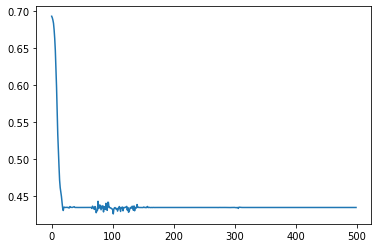

In [95]:

rank_model = RankNet(num_feature=n_feature)
optimizer = torch.optim.Adam(rank_model.parameters())
#optimizer = torch.optim.SGD(rank_model.parameters(),lr=0.1)
loss_fun = torch.nn.BCELoss()

rank_model.cuda()
# optimizer.cuda()
loss_fun.cuda()

data1 = data_1.cuda()
data2 = data_2.cuda()

y = y_true.cuda()


epoch = 500

losses = []

for i in range(epoch):
    
    rank_model.zero_grad()
    
    # encode the job title using BERT model
    embedding_1 = bert_model.encode(job_titlel_lst1)
    embedding_2 = bert_model.encode(job_titlel_lst2 )
    data_1 = torch.from_numpy(embedding_1).float()
    data_2 = torch.from_numpy(embedding_2).float()
    y_1_true = list(df_1['ranking_label'])
    y_2_true = list(df_2['ranking_label'])
    y_true = torch.tensor([1.0 if y1_i>y2_i else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y_1_true, y_2_true)]).float()
    y_true=y_true.unsqueeze(1)

    y_pred = rank_model(data1, data2)
    
    loss = loss_fun(y_pred,y)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i % 1 == 0:
    
        print('Epoch{}, loss : {}'.format(i, loss.item()))
    
    

import matplotlib.pyplot as plt
x = list(range(epoch))
plt.plot(x, losses)


In [70]:
# model is not improving after about 0.45. How to improve the model? Add more data, improve the model, change the learning rate, optimizer, droupout rate

Next steps:
Baysian optimization: library- hyperopt for pytorch example,
Learning rate , possible optimizers, Chenge the linear layer size